In [15]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import os
import pathlib
import random as rn
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.models import load_model
from sklearn.metrics import accuracy_score
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [16]:
data_dir = '../input/gtsrb-german-traffic-sign/'
train_path = '../input/gtsrb-german-traffic-sign/Train/'
test_path = '../input/gtsrb-german-traffic-sign/Test/'
height = 50
width = 50

In [17]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }


In [18]:
batch_size = 150
seed = 42

In [19]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)
train_dataset = train_datagen.flow_from_directory(train_path,
                                                  target_size=(height, width),
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  seed=seed,
                                                  color_mode='rgb',
                                                  interpolation='hamming',
                                                  subset='training')

test_datagen = ImageDataGenerator(rescale=1./255,
                                  validation_split=0.2)
test_dataset = test_datagen.flow_from_directory(train_path,
                                                target_size=(height, width),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True,
                                                seed=seed,
                                                color_mode='rgb',
                                                interpolation='hamming',
                                                subset='validation')

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


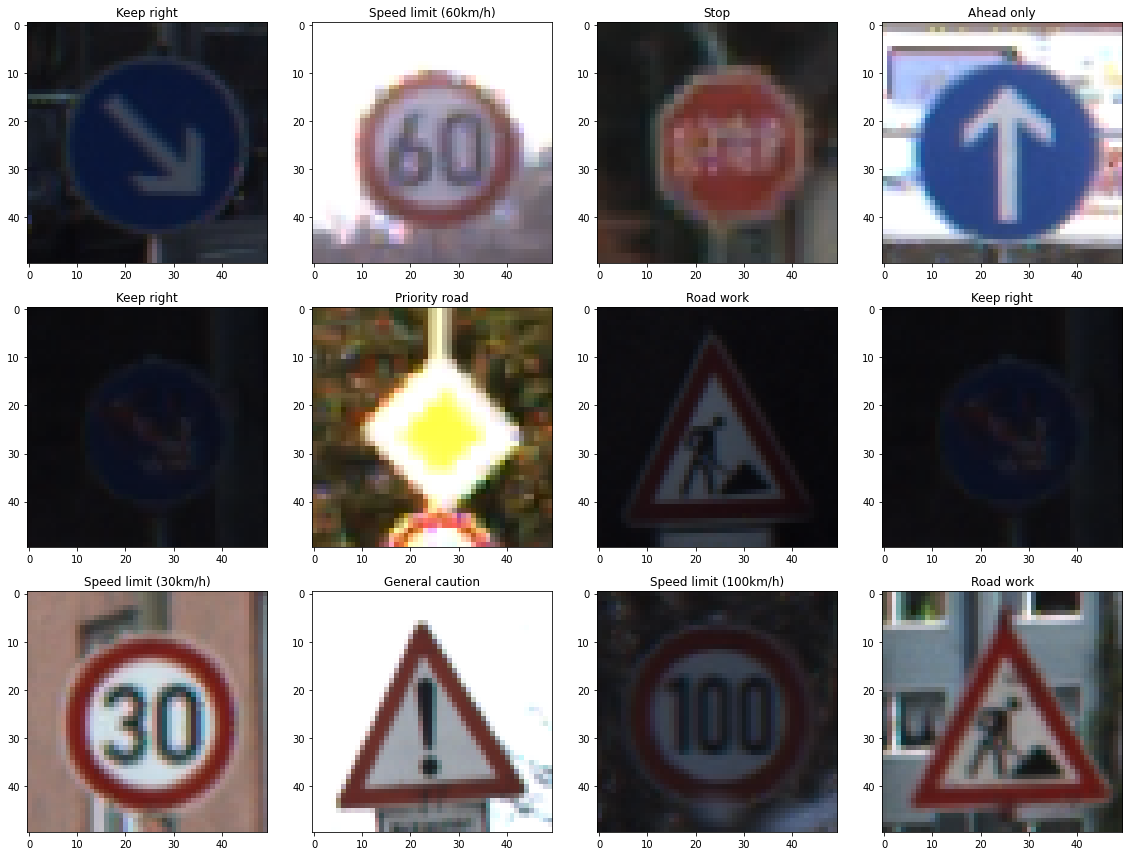

In [51]:
fig,ax=plt.subplots(3,4)
fig.set_size_inches(16,12)
img,y = train_dataset.next()
for i in range(3):
    for j in range (4):
        l=rn.randint(0,batch_size-1)
        label = classes[int(list(train_dataset.class_indices.keys())[np.argmax(y[l])])]
        ax[i,j].imshow(img[l])
        ax[i,j].set_title(label)

plt.tight_layout()

In [21]:
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(5,5), activation='relu', input_shape=(height,width,3)),
    keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.Dropout(rate=0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.25),
    
    keras.layers.Dense(43, activation='softmax')
])

2022-04-27 21:32:15.160149: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-27 21:32:15.161835: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-27 21:32:15.162992: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-27 21:32:15.164003: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 16)        1216      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 32)        12832     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 21, 21, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 21, 21, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 19, 19, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 17, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

In [23]:
alpha=0.01
epochs=15
optim = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [24]:
history = model.fit(train_dataset,
                    steps_per_epoch=len(train_dataset),
                    epochs=epochs,
                    validation_data=test_dataset,
                    validation_steps=len(test_dataset))

2022-04-27 21:32:18.238425: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2022-04-27 21:32:21.567401: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


210/210 [==============================] - 253s 1s/step - loss: 0.5661 - accuracy: 0.8520 - val_loss: 0.8750 - val_accuracy: 0.7818
Epoch 2/15
210/210 [==============================] - 45s 215ms/step - loss: 0.0709 - accuracy: 0.9783 - val_loss: 0.3494 - val_accuracy: 0.9263
Epoch 3/15
210/210 [==============================] - 46s 221ms/step - loss: 0.0418 - accuracy: 0.9871 - val_loss: 1.0069 - val_accuracy: 0.8063
Epoch 4/15
210/210 [==============================] - 45s 215ms/step - loss: 0.0356 - accuracy: 0.9886 - val_loss: 0.4889 - val_accuracy: 0.9144
Epoch 5/15
210/210 [==============================] - 45s 216ms/step - loss: 0.0220 - accuracy: 0.9930 - val_loss: 0.3725 - val_accuracy: 0.9307
Epoch 6/15
210/210 [==============================] - 46s 217ms/step - loss: 0.0404 - accuracy: 0.9882 - val_loss: 0.6900 - val_accuracy: 0.9013
Epoch 7/15
210/210 [==============================] - 46s 219ms/step - loss: 0.0324 - accuracy: 0.9910 - val_loss: 0.4310 - val_accuracy: 0.932

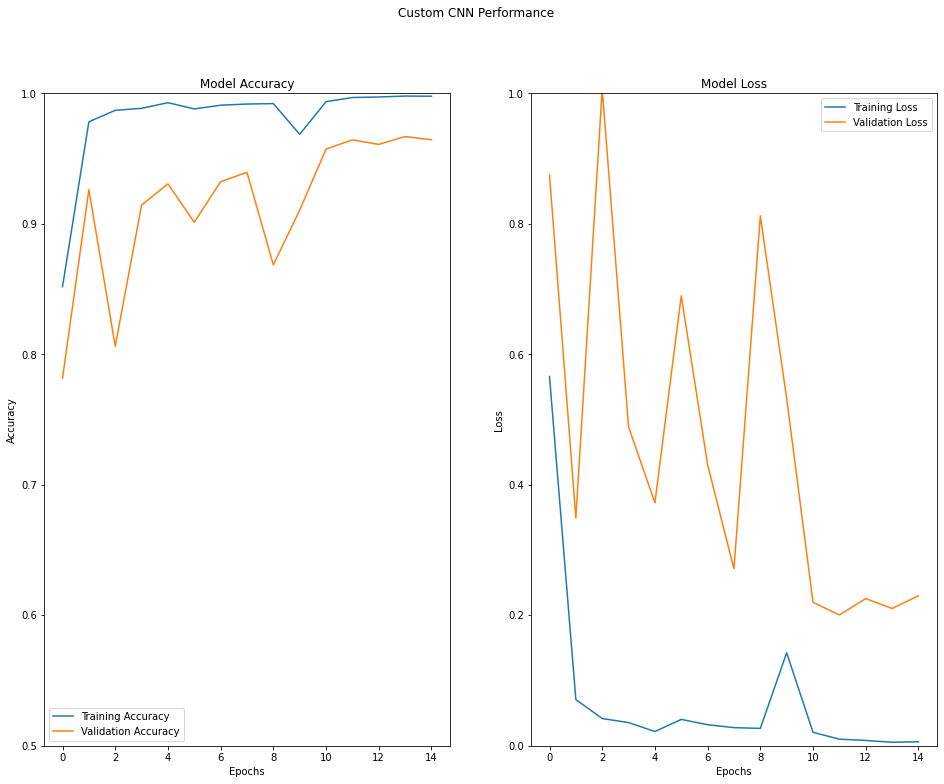

<Figure size 720x504 with 0 Axes>

In [48]:
fig,ax=plt.subplots(1,2)
fig.set_size_inches(16,12)
performance = pd.DataFrame(history.history)
plt.figure(figsize=(10,7))
ax[1].plot(performance[['loss','val_loss']])
ax[1].legend(['Training Loss', 'Validation Loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_ylim(0,1)
ax[0].plot(performance[['accuracy','val_accuracy']])
ax[0].legend(['Training Accuracy', 'Validation Accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim(0.5,1)
fig.suptitle('Custom CNN Performance')
plt.show()

In [26]:
model.save("CNN.h5")

In [82]:
def map_pred(pred):
    return [int(list(train_dataset.class_indices.keys())[i]) for i in pred]
test_df = pd.read_csv(data_dir + 'Test.csv')

test_labels = test_df["ClassId"].values
imgs = test_df["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((height, width))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

In [83]:
from sklearn.metrics import accuracy_score
pred = model.predict(X_test)
pred = map_pred(pred.argmax(axis=-1))
print('Test Data accuracy: ',accuracy_score(test_labels, pred)*100)

Test Data accuracy:  80.82343626286618


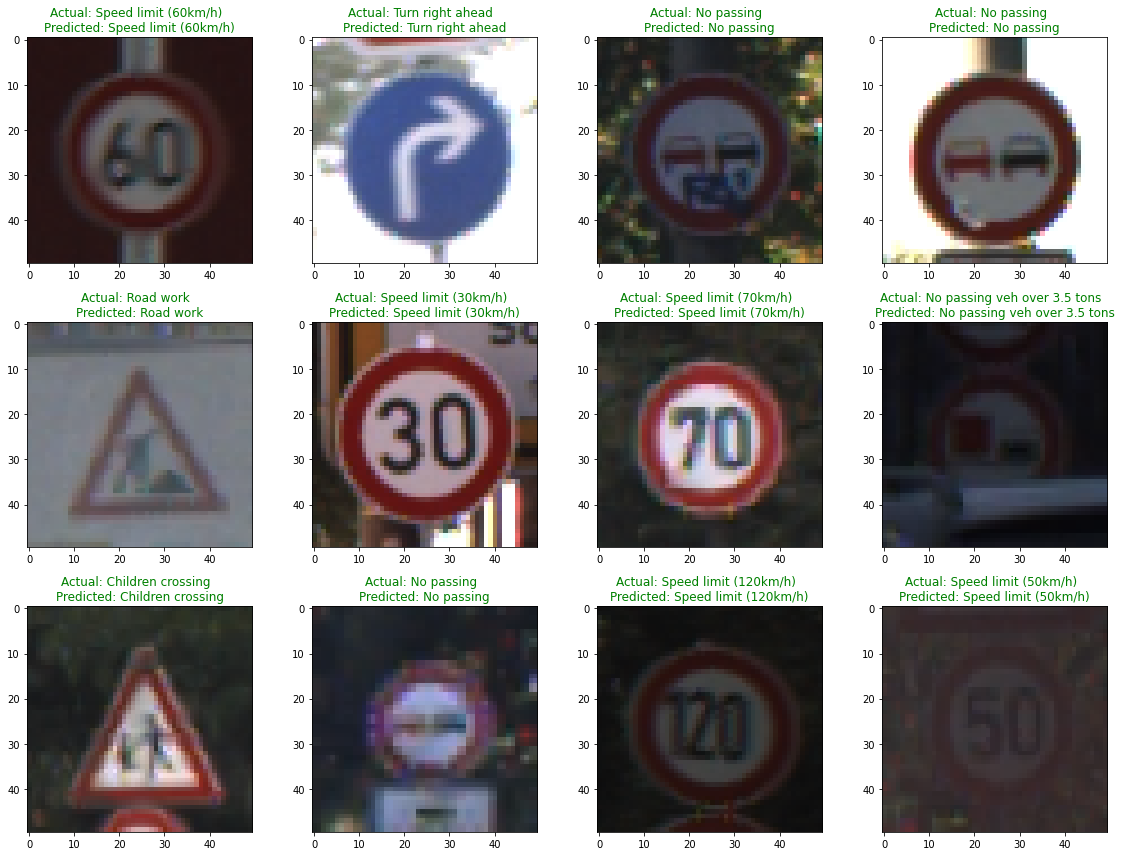

In [75]:
fig,ax=plt.subplots(3,4)
fig.set_size_inches(16,12)
val_images, val_labels = test_dataset.next()
predicted = model.predict(val_images)
predicts = map_pred(np.argmax(predicted, axis=-1))
labels = map_pred(np.argmax(val_labels, axis=-1))

for i in range(3):
    for j in range (4):
        idx=rn.randint(0,batch_size-1)
        ax[i,j].imshow(val_images[idx])
        if labels[idx] == predicts[idx]:
            ax[i,j].set_title('Actual: '+classes[labels[idx]]+'  \nPredicted: '+classes[predicts[idx]], color = 'green')
        else: 
            ax[i,j].set_title('Actual: '+classes[labels[idx]]+'  \nPredicted: '+classes[predicts[idx]], color = 'red')

plt.tight_layout()

In [88]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (height, width, 3), include_top = False, weights = "imagenet")
base_model.trainable = False

In [89]:
mob_model = tf.keras.Sequential([base_model,
                                   keras.layers.GlobalAveragePooling2D(),
                                   keras.layers.Dropout(0.2),
                                   keras.layers.Dense(512, activation='relu'),
                                   keras.layers.BatchNormalization(),
                                   keras.layers.Dropout(rate=0.2),
                                   keras.layers.Dense(43, activation='softmax')                                    
                                ])
mob_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 2, 2, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               655872    
_________________________________________________________________
batch_normalization_5 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 43)               

In [91]:
alpha=0.01
epochs=8
optim = keras.optimizers.Adam(learning_rate=alpha)
mob_model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
mob_history = mob_model.fit(train_dataset,
                          steps_per_epoch=len(train_dataset),
                          epochs=epochs,
                          validation_data=test_dataset,
                          validation_steps=len(test_dataset))

Epoch 1/8
210/210 [==============================] - 51s 226ms/step - loss: 1.3672 - accuracy: 0.5880 - val_loss: 2.0789 - val_accuracy: 0.4561
Epoch 2/8
210/210 [==============================] - 47s 222ms/step - loss: 0.8407 - accuracy: 0.7175 - val_loss: 2.1033 - val_accuracy: 0.4756
Epoch 3/8
210/210 [==============================] - 46s 220ms/step - loss: 0.7144 - accuracy: 0.7598 - val_loss: 2.0578 - val_accuracy: 0.4804
Epoch 4/8
210/210 [==============================] - 47s 226ms/step - loss: 0.6428 - accuracy: 0.7816 - val_loss: 2.1762 - val_accuracy: 0.4853
Epoch 5/8
210/210 [==============================] - 46s 218ms/step - loss: 0.5713 - accuracy: 0.8052 - val_loss: 2.2068 - val_accuracy: 0.4928
Epoch 6/8
210/210 [==============================] - 46s 219ms/step - loss: 0.5317 - accuracy: 0.8201 - val_loss: 2.4569 - val_accuracy: 0.4593
Epoch 7/8
210/210 [==============================] - 46s 221ms/step - loss: 0.4999 - accuracy: 0.8287 - val_loss: 2.2643 - val_accuracy:

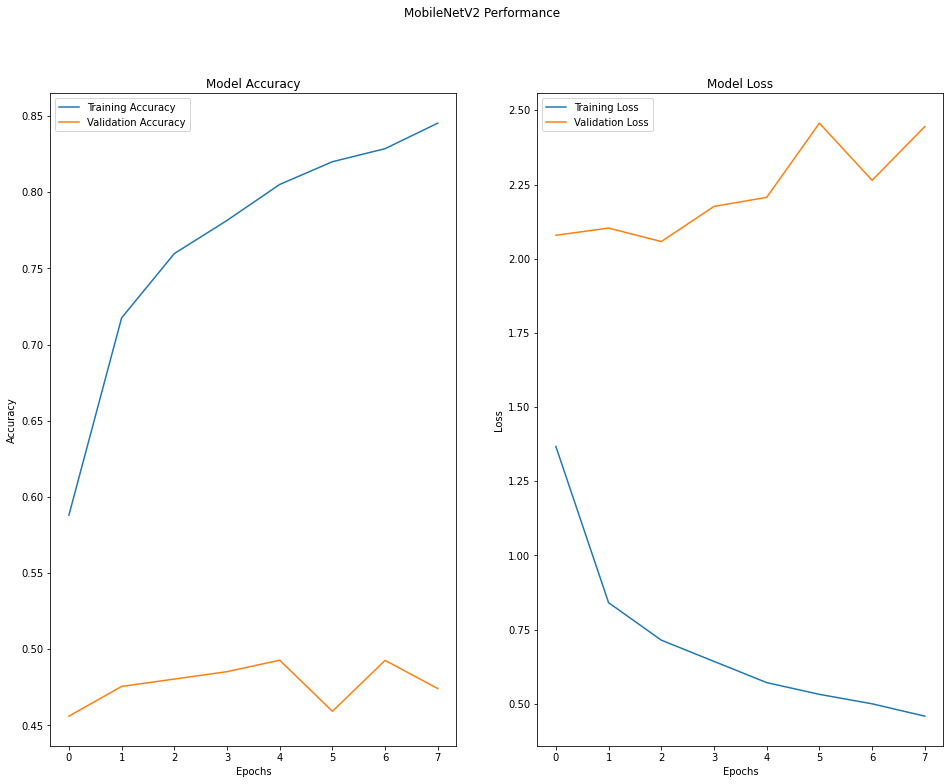

<Figure size 720x504 with 0 Axes>

In [96]:
fig,ax=plt.subplots(1,2)
fig.set_size_inches(16,12)
performance = pd.DataFrame(mob_history.history)
plt.figure(figsize=(10,7))
ax[1].plot(performance[['loss','val_loss']])
ax[1].legend(['Training Loss', 'Validation Loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
# ax[1].set_ylim(0,1)
ax[0].plot(performance[['accuracy','val_accuracy']])
ax[0].legend(['Training Accuracy', 'Validation Accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
# ax[0].set_ylim(0.5,1)
fig.suptitle('MobileNetV2 Performance')
plt.show()

In [93]:
from sklearn.metrics import accuracy_score
pred = mob_model.predict(X_test)
pred = map_pred(pred.argmax(axis=-1))
print('Test Data accuracy: ',accuracy_score(test_labels, pred)*100)

Test Data accuracy:  35.62945368171022


In [35]:
vgg_model = tf.keras.Sequential([VGG19(weights='imagenet', include_top=False, input_shape=(height,width,3)),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.Flatten(),
                                 keras.layers.Dense(512, activation='sigmoid'),
                                 keras.layers.Dense(43, activation='softmax')
                                ])

vgg_model.summary()

80150528/80134624 [==============================] - 2s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
batch_normalization_4 (Batch (None, 1, 1, 512)         2048      
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_5 (Dense)              (None, 43)                22059     
Total params: 20,311,147
Trainable params: 20,310,123
Non-trainable params: 1,024
_________________________________________________________________


In [36]:
alpha=0.0001
epochs=8
optim = keras.optimizers.Adam(learning_rate=alpha)
vgg_model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [37]:
vgg_history = vgg_model.fit(train_dataset,
                        steps_per_epoch=len(train_dataset),
                        epochs=epochs,
                        validation_data=test_dataset,
                        validation_steps=len(test_dataset))

Epoch 1/8
210/210 [==============================] - 53s 238ms/step - loss: 0.7533 - accuracy: 0.8495 - val_loss: 0.5790 - val_accuracy: 0.9513
Epoch 2/8
210/210 [==============================] - 49s 234ms/step - loss: 0.0539 - accuracy: 0.9937 - val_loss: 0.1357 - val_accuracy: 0.9747
Epoch 3/8
210/210 [==============================] - 49s 232ms/step - loss: 0.0298 - accuracy: 0.9953 - val_loss: 0.0650 - val_accuracy: 0.9838
Epoch 4/8
210/210 [==============================] - 49s 235ms/step - loss: 0.0163 - accuracy: 0.9972 - val_loss: 0.0841 - val_accuracy: 0.9791
Epoch 5/8
210/210 [==============================] - 48s 231ms/step - loss: 0.0106 - accuracy: 0.9985 - val_loss: 0.0710 - val_accuracy: 0.9818
Epoch 6/8
210/210 [==============================] - 50s 236ms/step - loss: 0.0062 - accuracy: 0.9992 - val_loss: 0.0653 - val_accuracy: 0.9838
Epoch 7/8
210/210 [==============================] - 49s 235ms/step - loss: 0.0030 - accuracy: 0.9999 - val_loss: 0.0543 - val_accuracy:

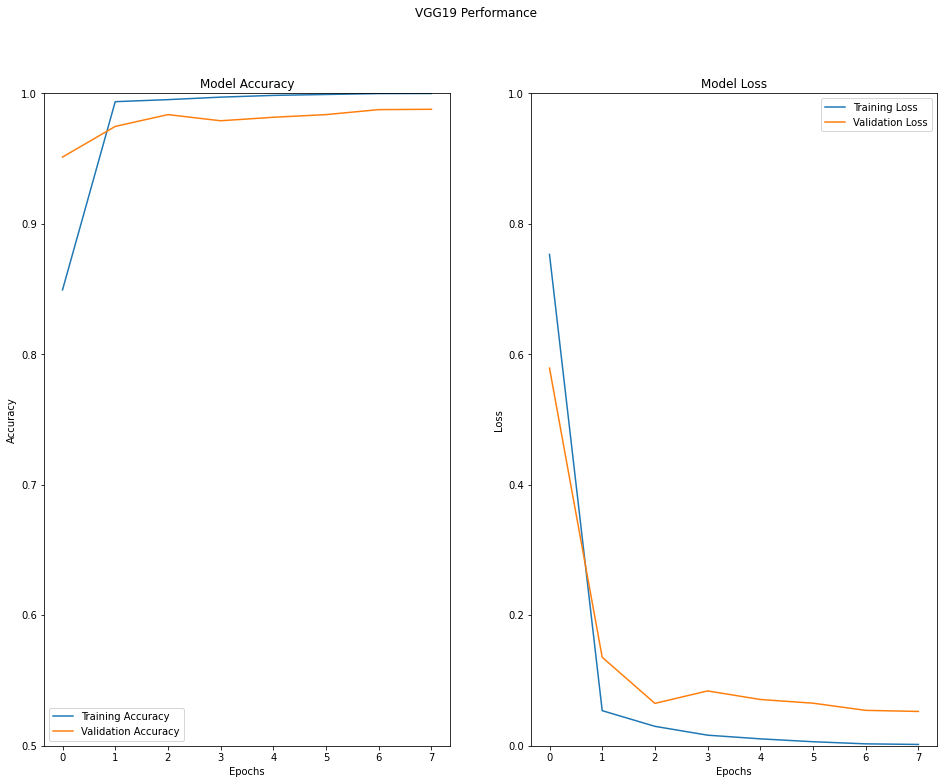

<Figure size 720x504 with 0 Axes>

In [45]:
fig,ax=plt.subplots(1,2)
fig.set_size_inches(16,12)
performance = pd.DataFrame(vgg_history.history)
plt.figure(figsize=(10,7))
ax[1].plot(performance[['loss','val_loss']])
ax[1].legend(['Training Loss', 'Validation Loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_ylim(0,1)
ax[0].plot(performance[['accuracy','val_accuracy']])
ax[0].legend(['Training Accuracy', 'Validation Accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim(0.5,1)
fig.suptitle('VGG19 Performance')
plt.show()

In [86]:
from sklearn.metrics import accuracy_score
pred = vgg_model.predict(X_test)
pred = map_pred(pred.argmax(axis=-1))
print('Test Data accuracy: ',accuracy_score(test_labels, pred)*100)

Test Data accuracy:  88.88361045130641


In [40]:
vgg_model.save("VGG.h5")

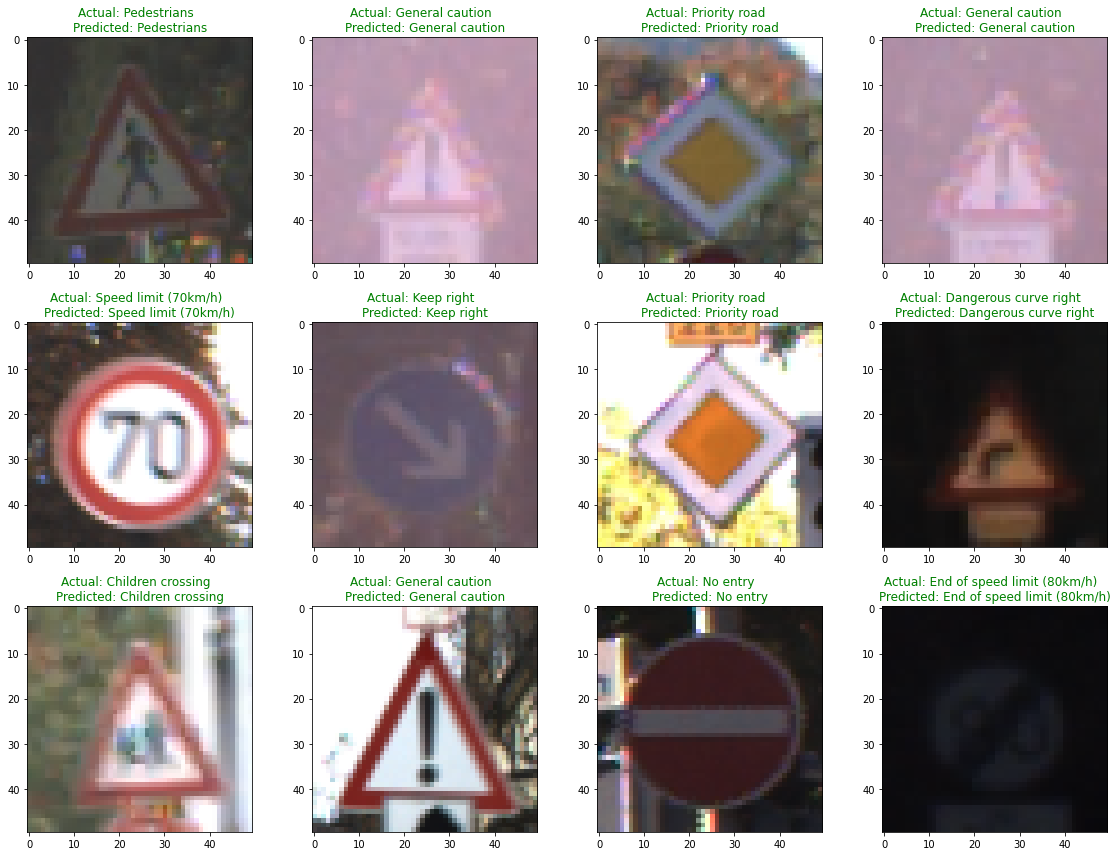

In [84]:
fig,ax=plt.subplots(3,4)
fig.set_size_inches(16,12)
val_images, val_labels = test_dataset.next()
predicted = vgg_model.predict(val_images)
predicts = map_pred(np.argmax(predicted, axis=-1))
labels = map_pred(np.argmax(val_labels, axis=-1))
for i in range(3):
    for j in range (4):
        idx=rn.randint(0,batch_size-1)
        ax[i,j].imshow(val_images[idx])
        if labels[idx] == predicts[idx]:
            ax[i,j].set_title('Actual: '+classes[labels[idx]]+'  \nPredicted: '+classes[predicts[idx]], color = 'green')
        else: 
            ax[i,j].set_title('Actual: '+classes[labels[idx]]+'  \nPredicted: '+classes[predicts[idx]], color = 'red')

plt.tight_layout()